## Загрузка

In [6]:
import importlib.util, sys, gdown

import pandas as pd 
import matplotlib.pyplot as plt 
 
import numpy as np 
from tensorflow.keras.optimizers import Adam 
from keras.models import Sequential, Model # Два варианты моделей
from keras.layers import concatenate,Reshape, Input,Conv2DTranspose, Lambda, Dense, Dropout, BatchNormalization, Flatten, Conv1D, Conv2D, LSTM, MaxPooling1D, Activation, GlobalMaxPooling1D, UpSampling1D, AveragePooling1D #Стандартные слои
from keras.losses import MAE
from sklearn.preprocessing import StandardScaler, MinMaxScaler 
from tensorflow.keras.preprocessing.sequence import TimeseriesGenerator 
import random as random
import time
from keras.callbacks import ReduceLROnPlateau, ModelCheckpoint
from keras.models import load_model
import pickle

In [13]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
url = 'https://storage.googleapis.com/aiu_bucket/data.zip'
output = 'data.zip' # Указываем имя файла, в который сохраняем файл
gdown.download(url, output, quiet=True) # Скачиваем файл по указанному URL

'data.zip'

In [3]:
!unzip -q data.zip -d ''

## Основной блок

In [3]:
import utils # Подключаем набор функций

**Загрузка данных**

In [6]:
train_dataset, val_dataset = utils.getData() # Загружаем обучающий и проверочный датасет

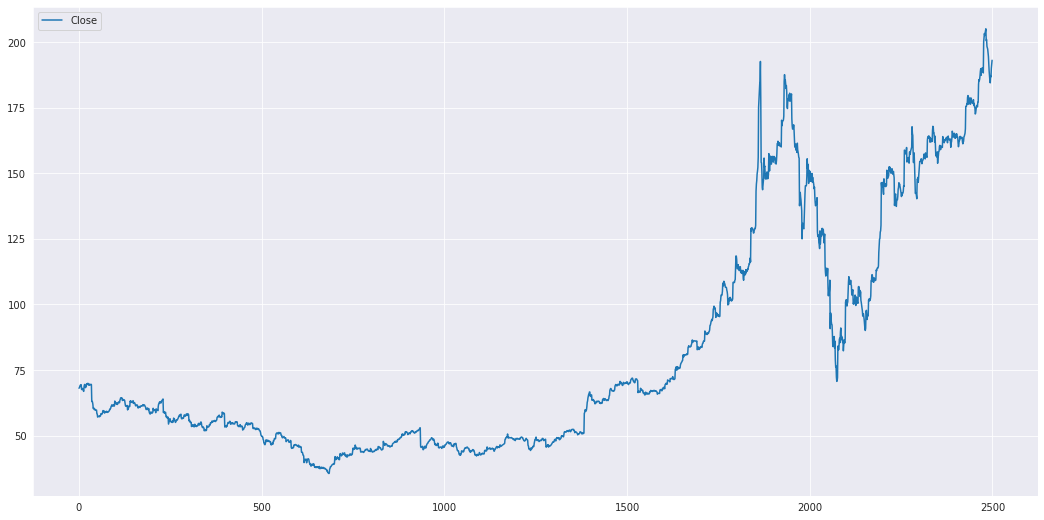

In [ ]:
utils.show_data(train_dataset, start=0, end=2500, param=['Close']) # Визуализируем обучающий датасет

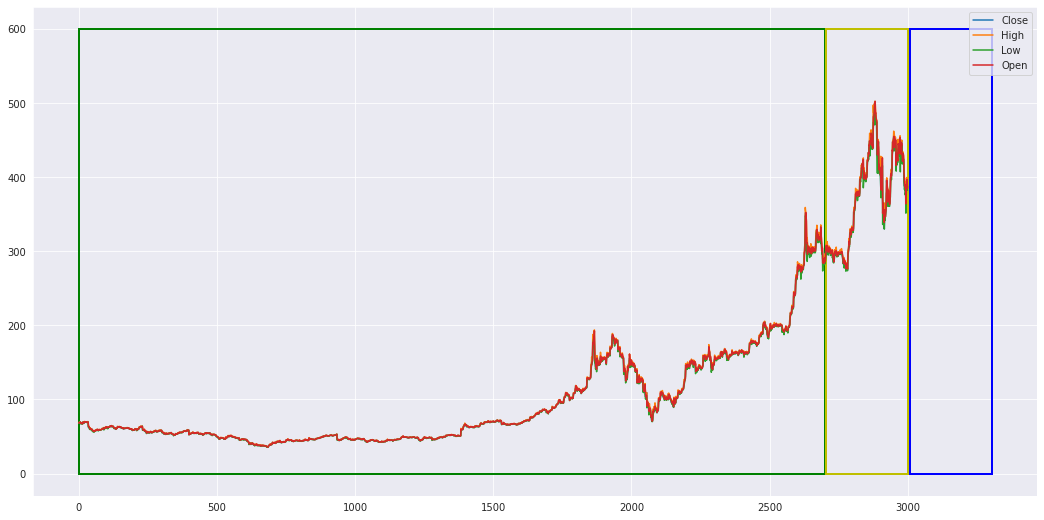

In [ ]:
utils.show_full_data(train_dataset, val_dataset,param=['Close','High','Low','Open'])

In [18]:
# Функция рассчитываем результаты прогнозирования сети
# В аргументы принимает сеть (currModel) и проверочную выборку
# Выдаёт результаты предсказания predVal
# И правильные ответы в исходной размерности yValUnscaled (какими они были до нормирования)
def getPred(currModel, xVal, yVal, yScaler):
  # Предсказываем ответ сети по проверочной выборке
  # И возвращаем исходны масштаб данных, до нормализации
  predVal = yScaler.inverse_transform(currModel.predict(xVal))
  yValUnscaled = yScaler.inverse_transform(yVal)
  
  return (predVal, yValUnscaled)

# Функция визуализирует графики, что предсказала сеть и какие были правильные ответы
# start - точка с которой начинаем отрисовку графика
# step - длина графика, которую отрисовываем
# channel - какой канал отрисовываем
def showPredict(start, step, channel, predVal, yValUnscaled):
  plt.plot(predVal[start:start+step, 0],
           label='Прогноз')
  plt.plot(yValUnscaled[start:start+step, channel], 
           label='Базовый ряд')
  plt.xlabel('Время')
  plt.ylabel('Значение Close')
  plt.legend()
  plt.show()
  
# Функция расёта корреляции дух одномерных векторов
def correlate(a, b):
  # Рассчитываем основные показатели
  ma = a.mean() # Среднее значение первого вектора
  mb = b.mean() # Среднее значение второго вектора
  mab = (a*b).mean() # Среднее значение произведения векторов
  sa = a.std() # Среднеквадратичное отклонение первого вектора
  sb = b.std() # Среднеквадратичное отклонение второго вектора
  
  #Рассчитываем корреляцию
  val = 1
  if ((sa>0) & (sb>0)):
    val = (mab-ma*mb)/(sa*sb)
  return val

# Функция рисуем корреляцию прогнозированного сигнала с правильным
# Смещая на различное количество шагов назад
# Для проверки появления эффекта автокорреляции
# channels - по каким каналам отображать корреляцию
# corrSteps - на какое количество шагов смещать сигнал назад для рассчёта корреляции
def showCorr(channels, corrSteps, predVal, yValUnscaled):
  # Проходим по всем каналам
  for ch in channels:
    corr = [] # Создаём пустой лист, в нём будут корреляции при смезении на i рагов обратно
    yLen = yValUnscaled.shape[0] # Запоминаем размер проверочной выборки

      # Постепенно увеличикаем шаг, насколько смещаем сигнал для проверки автокорреляции
    for i in range(corrSteps):
      # Получаем сигнал, смещённый на i шагов назад
      # predVal[i:, ch]
      # Сравниваем его с верными ответами, без смещения назад
      # yValUnscaled[:yLen-i,ch]
      # Рассчитываем их корреляцию и добавляем в лист
      corr.append(correlate(yValUnscaled[:yLen-i,ch], predVal[i:, 0]))

    own_corr = [] # Создаём пустой лист, в нём будут корреляции при смезении на i рагов обратно

      # Постепенно увеличикаем шаг, насколько смещаем сигнал для проверки автокорреляции
    for i in range(corrSteps):
      # Получаем сигнал, смещённый на i шагов назад
      # predVal[i:, ch]
      # Сравниваем его с верными ответами, без смещения назад
      # yValUnscaled[:yLen-i,ch]
      # Рассчитываем их корреляцию и добавляем в лист
      own_corr.append(correlate(yValUnscaled[:yLen-i,ch], yValUnscaled[i:, ch]))

    # Отображаем график коррелций для данного шага
    plt.plot(corr, label='Предсказание на ' + str(ch+1) + ' шаг')
    plt.plot(own_corr, label='Эталон')

  plt.xlabel('Время')
  plt.ylabel('Значение')
  plt.legend()
  plt.show()

def autoCorr(channels, corrSteps, predVal, yValUnscaled, showGraf = True, returnData = False):
  # Проходим по всем каналам
  for ch in channels:
    corr = [] # Создаём пустой лист, в нём будут корреляции при смезении на i рагов обратно
    yLen = yValUnscaled.shape[0] # Запоминаем размер проверочной выборки

      # Постепенно увеличикаем шаг, насколько смещаем сигнал для проверки автокорреляции
    for i in range(corrSteps):
      # Получаем сигнал, смещённый на i шагов назад
      # predVal[i:, ch]
      # Сравниваем его с верными ответами, без смещения назад
      # yValUnscaled[:yLen-i,ch]
      # Рассчитываем их корреляцию и добавляем в лист
      corr.append(correlate(yValUnscaled[:yLen-i,ch], predVal[i:, ch]))

    own_corr = [] # Создаём пустой лист, в нём будут корреляции при смезении на i рагов обратно

      # Постепенно увеличикаем шаг, насколько смещаем сигнал для проверки автокорреляции
    for i in range(corrSteps):
      # Получаем сигнал, смещённый на i шагов назад
      # predVal[i:, ch]
      # Сравниваем его с верными ответами, без смещения назад
      # yValUnscaled[:yLen-i,ch]
      # Рассчитываем их корреляцию и добавляем в лист
      own_corr.append(correlate(yValUnscaled[:yLen-i,ch], yValUnscaled[i:, ch]))

    # Отображаем график коррелций для данного шага
    if showGraf: #Если нужно показать график
      plt.plot(corr, label='предсказание на ' + str(ch+1) + ' шаг')
      plt.plot(own_corr, label='Эталон')

  if showGraf: #Если нужно показать график
    plt.xlabel('Время')
    plt.ylabel('Значение')
    plt.legend()
    plt.show()

  if returnData: #Если нужно вернуть массивы автокорреляции
    return corr, own_corr

**Блок создания нейронной сети**

In [ ]:
# проанализируем, как часто меняется тренд в графике на имеющихся данных, чтобы прикинуть оптимальный xLen. будем учитывать только значимые тренды (будем брать среднее из 10 значений)
# и смотреть, меняется ли у знак у тренда. Таким образом можно будет тестрировать различные гипотезы по поводу xLen более осознанно.

df1 =  train_dataset.append(val_dataset).reset_index()
trnd = df1.iloc[:]['Close'].values

trndAvr = []

for i,el in enumerate(trnd):
  if i%10 == 0:
    trndAvr.append(sum(trnd[(i-10):i])/10)

trndUp = 0
trndDown = 0
trndGen = []

for i in range(1, len(trndAvr)):
  if trndAvr[i-1] > trndAvr[i]:
    trndDown += 1 # тренд на снижение
    trndGen.append(0)
  else:
    trndUp += 1   # тренд на повышение
    trndGen.append(1)

signChange = 0

for i in range(1, len(trndGen)):
  if trndGen[i] == trndGen[i-1]:
    continue
  else:
    signChange+=1

print('трендов на повышение в графике', trndUp, '\nтрендов на понижение в графике', trndDown)
print('кол-во раз, когда менялся знак (за 3000 отсчетов) =', signChange*10)
print('каждый 3 отсчет(час) в среднем идет смена тренда')


трендов на повышение в графике 173 
трендов на понижение в графике 126
кол-во раз, когда менялся знак (за 3000 отсчетов) = 1150
каждый 3 отсчет(час) в среднем идет смена тренда


In [15]:
# расширим базу начальных значений для ухода 

new_train_dataset = pd.DataFrame()
new_train_dataset[['Open2','High2','Low2', 'Close2', 'Volume2']] = np.square(train_dataset)
new_train_dataset[['Open05','High05','Low05', 'Close05', 'Volume05']] = np.sqrt(train_dataset)
new_train_dataset = new_train_dataset.assign(Diff1 = train_dataset.Open - train_dataset.Close, Diff2 = train_dataset.High - train_dataset.Low)

new_val_dataset = pd.DataFrame()
new_val_dataset[['Open2','High2','Low2', 'Close2', 'Volume2']] = np.square(val_dataset)
new_val_dataset[['Open05','High05','Low05', 'Close05', 'Volume05']] = np.sqrt(val_dataset)
new_val_dataset = new_val_dataset.assign(Diff1 = val_dataset.Open - val_dataset.Close, Diff2 = val_dataset.High - val_dataset.Low)


In [16]:
new_train_dataset = np.array(new_train_dataset)
new_val_dataset = np.array(new_val_dataset)

In [17]:
# Нормируем

xLen = 20 # будем брать по xLen отчетов для анализа

xTrain, yTrain = new_train_dataset[:-xLen+1], new_train_dataset[:-xLen+1, 3] # формируем xTrain и yTrain, которые не будут пересекаться с валдиационной выборкой.
xVal, yVal = new_val_dataset[:], new_val_dataset[:,3] # то же самое для валидационной выборки

# Нормируем значения (отдельно для таблицы значений входных параметров X и отдельно для вектора значений Close Y)

forScale = np.concatenate([new_train_dataset,new_val_dataset])

xScaler = MinMaxScaler()
xScaler.fit(forScale)
xTrain = xScaler.transform(forScale[0:2700-xLen+1])
xVal = xScaler.transform(forScale[2700-xLen+1:])

yTrain = np.array(forScale[0:2700-xLen+1,3].reshape(-1,1))
yVal = np.array(forScale[2700-xLen+1:,3].reshape(-1,1))

yScaler = MinMaxScaler()
yScaler.fit(yTrain)
yTrain = yScaler.transform(yTrain)
yVal = yScaler.transform(yVal)


In [174]:
#Создаем генератор для обучения

sampl_rt = 20
strd = 1

trainDataGen = TimeseriesGenerator(xTrain, yTrain,           #В качестве параметров наши выборки
                               length=xLen, stride=strd,
                               sampling_rate = sampl_rt,            #Для каждой 5 точки (из промежутка длины xLen) для проноза на 5 часов вперед
                               batch_size=20)                #Размер batch, который будем скармливать модели

#Создаем аналогичный генератор для валидации при обучении
testDataGen = TimeseriesGenerator(xVal, yVal,
                               length=xLen, stride=strd,
                               sampling_rate = sampl_rt,
                               batch_size=20)
print('sr = ', sampl_rt)

sr =  20


In [175]:
#Выигравшая конфигурация. Работаем дальше с ней.

input_shape = (int(xLen/sampl_rt),12)

modelD = Sequential()

modelD.add(Dense(1024, activation="elu", input_shape = input_shape))
modelD.add(Conv1D(256, 20, activation = 'tanh', padding = 'same'))
modelD.add(Flatten())

modelD.add(Dense(1024, activation = 'tanh'))
modelD.add(Dense(1, activation = 'elu'))

#Компилируем
modelD.compile(loss="mse", optimizer=Adam(lr=1e-5))


Epoch 1/70
134/134 [==============================] - 1s 6ms/step - loss: 0.0143 - val_loss: 0.7317
Epoch 2/70
134/134 [==============================] - 1s 5ms/step - loss: 0.0056 - val_loss: 0.3791
Epoch 3/70
134/134 [==============================] - 1s 5ms/step - loss: 0.0039 - val_loss: 0.3038
Epoch 4/70
134/134 [==============================] - 1s 5ms/step - loss: 0.0042 - val_loss: 0.2887
Epoch 5/70
134/134 [==============================] - 1s 5ms/step - loss: 0.0032 - val_loss: 0.2420
Epoch 6/70
134/134 [==============================] - 1s 5ms/step - loss: 0.0028 - val_loss: 0.1991
Epoch 7/70
134/134 [==============================] - 1s 5ms/step - loss: 0.0023 - val_loss: 0.1603
Epoch 8/70
134/134 [==============================] - 1s 5ms/step - loss: 0.0024 - val_loss: 0.1471
Epoch 9/70
134/134 [==============================] - 1s 5ms/step - loss: 0.0016 - val_loss: 0.1218
Epoch 10/70
134/134 [==============================] - 1s 5ms/step - loss: 0.0021 - val_loss: 0.1218

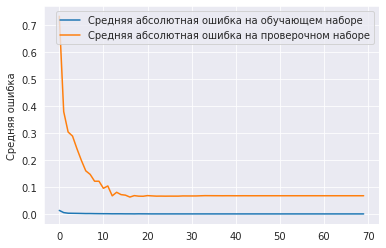

In [176]:
#Запускаем обучение

reduce_lr = ReduceLROnPlateau(monitor = 'val_loss', mode = 'min', patience = 4, cooldown = 10, verbose = 1)
save_bst = ModelCheckpoint(f'/content/drive/MyDrive/AIU/Конкурс Трейдинг/step{sampl_rt}.h5', save_best_only = True)

history = modelD.fit(
                    trainDataGen, 
                    epochs=70, 
                    verbose=1, 
                    validation_data = testDataGen, callbacks = [reduce_lr, save_bst] 
                    )

#Выводим графики
plt.plot(history.history['loss'], 
         label='Средняя абсолютная ошибка на обучающем наборе')
plt.plot(history.history['val_loss'], 
         label='Средняя абсолютная ошибка на проверочном наборе')
plt.ylabel('Средняя ошибка')
plt.legend()
plt.show()

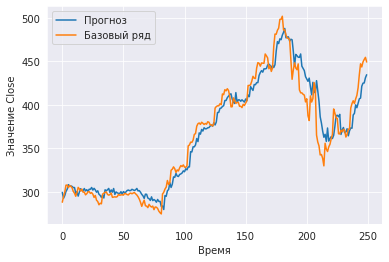

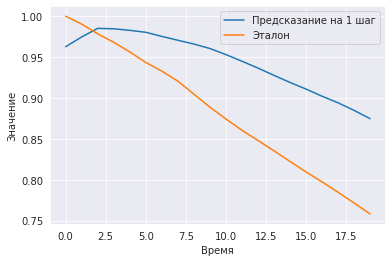

In [154]:
#Создадим генератор проверочной выборки, из которой потом вытащим xVal, yVal для проверки
DataGen = TimeseriesGenerator(xVal, yVal,
                              length=xLen, stride=strd,
                              sampling_rate = sampl_rt, 
                              batch_size=len(xVal)) #размер batch будет равен длине нашей выборки
xValg = []
yValg = []
for i in DataGen:
  xValg.append(i[0])
  yValg.append(i[1])

xValg = np.array(xValg)
yValg = np.array(yValg)

#Прогнозируем данные текущей сетью
currModel = modelD #Выбираем текущую модель
(predVal, yValUnscaled) = getPred(currModel, xValg[0], yValg[0], yScaler) #Прогнозируем данные

#Отображаем графики
showPredict(0, 250, 0, np.sqrt(predVal), np.sqrt(yValUnscaled)) # 250 отчетов с шагом 5 
showCorr([0], 20, predVal, yValUnscaled)

**Блок тестирования модели**

In [ ]:
train_dataset, val_dataset = utils.getData()

# Ваша стратегия
money = 100000 # Стартовый капитал
shares = 0 # Стартовое количество акций
dataset = train_dataset.append(val_dataset).reset_index() # Объединяем обучающий и проверочный датасеты

# Проходим по всему тестовому датасету
for i in range(1, test_dataset.shape[0]+1):
  df = dataset.append(test_dataset[:i]).reset_index() # Считываем очередное значение из тестового датасета
  '''
  Здесь должна быть Ваша стратегия
  '''
  pass 

In [8]:
# Эту функцию можно использовать для проверки тестовой выборки.

model5 = load_model('/content/drive/MyDrive/AIU/Конкурс Трейдинг/step5.h5')
model10 = load_model('/content/drive/MyDrive/AIU/Конкурс Трейдинг/step10.h5')
yScaler = pickle.load(open('/content/drive/MyDrive/AIU/Конкурс Трейдинг/yScaler.pkl','rb'))
xScaler = pickle.load(open('/content/drive/MyDrive/AIU/Конкурс Трейдинг/xScaler.pkl','rb'))

def trade(df, xLen = 20, modelUp = model10, modelDown = model5):

  srDown = 5
  srUp = 10


  short = 0
  act = 0
  purchase_price = 0
  df = df.drop('index', axis=1)
  
  dfh = pd.DataFrame()
  dfh[['Open2','High2','Low2', 'Close2', 'Volume2']] = np.square(df)
  dfh[['Open05','High05','Low05', 'Close05', 'Volume05']] = np.sqrt(df)
  dfh = dfh.assign(Diff1 = df.Open - df.Close, Diff2 = df.High - df.Low)

  dfhUp = dfh.iloc[::srUp] # берем каждый SR-ный элемент датафрейма (в зав-ти от шага)
  dfhDown = dfh.iloc[::srDown]


  xValUp = dfhUp.iloc[-int(xLen/srUp):,[0,1,2,3,4,5,6,7,8,9,10,11]].values # возьмем последние n значений из текущего ряда значений
  xValUp = xScaler.transform(xValUp) # нормируем значения

  xValDown = dfhDown.iloc[-int(xLen/srDown):,[0,1,2,3,4,5,6,7,8,9,10,11]].values 
  xValDown = xScaler.transform(xValDown)



  predUp = np.sqrt(yScaler.inverse_transform(modelUp.predict(xValUp.reshape(1, int(xLen/srUp), 12)))[0][0]) # смотрим, что предскажет модель. Модель смотрит на 1 шаг вперед.
  predDown = np.sqrt(yScaler.inverse_transform(modelDown.predict(xValDown.reshape(1, int(xLen/srDown), 12)))[0][0])


  if (df.iloc[-2]['Close'] < df.iloc[-1]['Close']) and (np.mean(df.iloc[-2:]['Close']) < predUp): # если тренд планирует идти вверх, покупаем и запоминаем цену покупки
    act = 1 # buy shares
    purchase_price = df.iloc[-1]['Close']
  
  elif (df.iloc[-2]['Close'] > df.iloc[-1]['Close']) and (np.mean(df.iloc[-2:]['Close']) > predUp): # когда тренд пошел на спад, продаем акции
    act = 2 # sell shares
  
  if act == 2 and np.mean(df.iloc[-2:]['Close']) > predDown:
    short = 1 # берем акции в долг у брокера 

  elif act == 1:
    short = 2 # возвращаем акции брокеру по низкой цене и высвобождаем деньги для покупки акций. 

  return act, short

Купили
Цена: 288.23602294921875
Денег: 0
Акций: 346.9378982432669
Акций в шорт: 0
2
------------------------
Продали
Цена: 304.9620056152344
Денег: 105802.87727220077
Акций: 0
Акций в шорт: 0
7
------------------------
Взяли в шорт
Цена: 304.9620056152344
Денег: 105802.87727220077
Акций: 0
Акций в шорт: 346.9378982432669
7
------------------------
Продали
Цена: 306.53460693359375
Денег: 105802.87727220077
Акций: 0
Акций в шорт: 346.9378982432669
9
------------------------
Продали
Цена: 304.8340148925781
Денег: 105802.87727220077
Акций: 0
Акций в шорт: 346.9378982432669
10
------------------------
Купили
Цена: 299.302001953125
Денег: 0
Акций: 353.49872898201005
Акций в шорт: 346.9378982432669
14
------------------------
Отдали акции брокеру
Цена: 299.302001953125
Денег: 1963.6697745814204
Акций: 353.49872898201005
Акций в шорт: 0
14
------------------------
Купили
Цена: 305.2980041503906
Денег: 0
Акций: 359.93070609252567
Акций в шорт: 0
15
------------------------
Продали
Цена: 308.563

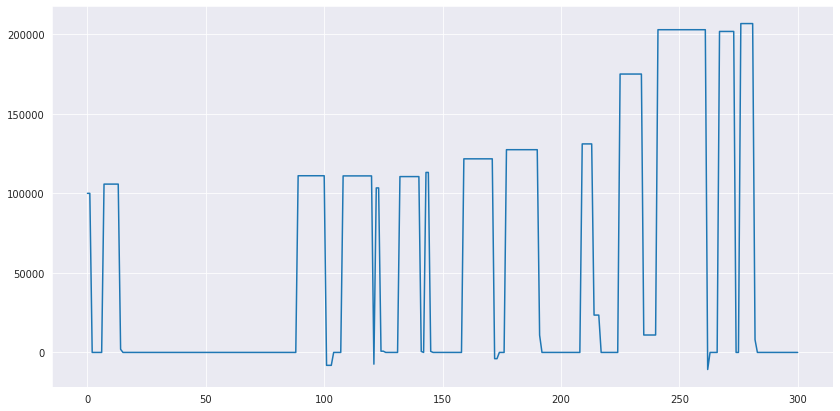

In [9]:
train_dataset, val_dataset = utils.getData() # Загружаем обучающий и проверочный датасет

# Ваша стратегия
money = 100000 # Стартовый капитал
shares = 0 # Стартовое количество акций
sharesCrdt = 0 # акции, взятые у брокера
shCrPrice = 0 # стоимость акции, при взятии их в долг у брокера
crMoney = money # кол-во денег, на которые можно взять в долг акций у брокера. **Зависит от текущего баланса средств на счету по условию конкурса. 
dataset = train_dataset # В dataset записываем обучающий набор
money_history = [money] # Статистика капитала

# Проходим по всему проверочному набору
for i in range(1, val_dataset.shape[0]+1):
  df = train_dataset.append(val_dataset[:i]).reset_index() # Считываем очередное значение из проверочного набора
  
  action, short = trade(df) # Получаем действие, которое будем совершать
 
  # Если это последнее значение тестовой выборки

  # Если должны покупать и есть деньги хотя бы на одну акцию
  if action==1 and money != 0:
    shares += money / df.iloc[-1]['Close'] # Покупаем на все имеющиеся деньги акции 
    money = 0 # покупаем на все деньги

    
    # Выводим статистическую информацию
    print('Купили')
    print('Цена:', df.iloc[-1]['Close'])
    print('Денег:', money)
    print('Акций:', shares)
    print('Акций в шорт:', sharesCrdt)
    print(i)
   
    print('------------------------')

  # Если должны продавать
  elif action==2:
    money += shares * df.iloc[-1]['Close'] # Продаем все акции и увеличиваем капитал на заработанные деньги
    shares = 0 # Количество акцией сбрасываем в 0
    
    # Выводим статистическую информацию
    print('Продали')
    print('Цена:', df.iloc[-1]['Close'])
    print('Денег:', money)
    print('Акций:', shares)
    print('Акций в шорт:', sharesCrdt)
    print(i)
    print('------------------------')  


  # если берем вдолг акции у брокера 
  if short == 1 and crMoney!= 0: 
    sharesCrdt += money / df.iloc[-1]['Close'] # Берем акции у брокера по биржевой цене
    crMoney = 0 # кредитуемся "на все"
    shCrPrice = df.iloc[-1]['Close'] # запоминаем стоимость акций на момент взятия долга
    
    # Выводим статистическую информацию
    print('Взяли в шорт')
    print('Цена:', df.iloc[-1]['Close'])
    print('Денег:', money)
    print('Акций:', shares)
    print('Акций в шорт:', sharesCrdt)
    print(i)
    print('------------------------')  

  if short == 2 and sharesCrdt !=0 : 
    money += (shCrPrice - df.iloc[-1]['Close']) * sharesCrdt # Отдаем все взятые в долг акции брокеру по текущей биржевой цене. Считаем выручку.
    sharesCrdt = 0 # обновляем кол-во акций, взятых в долг у брокера
    crMoney = money # обновляем наш кредитный кошелек
    
    # Выводим статистическую информацию
    print('Отдали акции брокеру')
    print('Цена:', df.iloc[-1]['Close'])
    print('Денег:', money)
    print('Акций:', shares)
    print('Акций в шорт:', sharesCrdt)
    print(i)
  
    print('------------------------')   

  
  money_history.append(money) # Записываем в статистику капитала текущее значение имеющихся денег

# Выводим статистику изменения капитала
plt.figure(figsize=(14,7))
plt.plot(money_history)
plt.show()


In [59]:
print('Финальный результат: ', round(money,2), 'руб.')

Финальный результат:  0 руб.


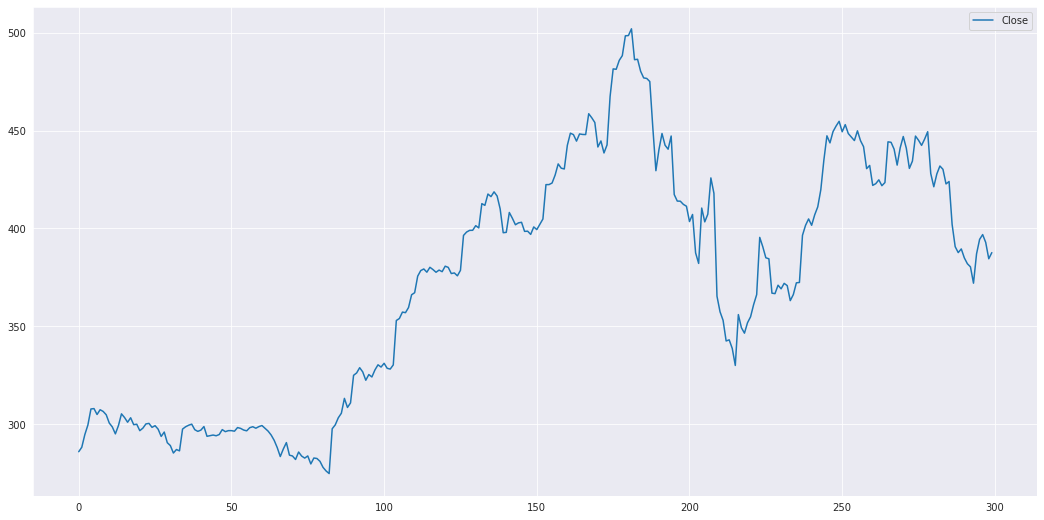

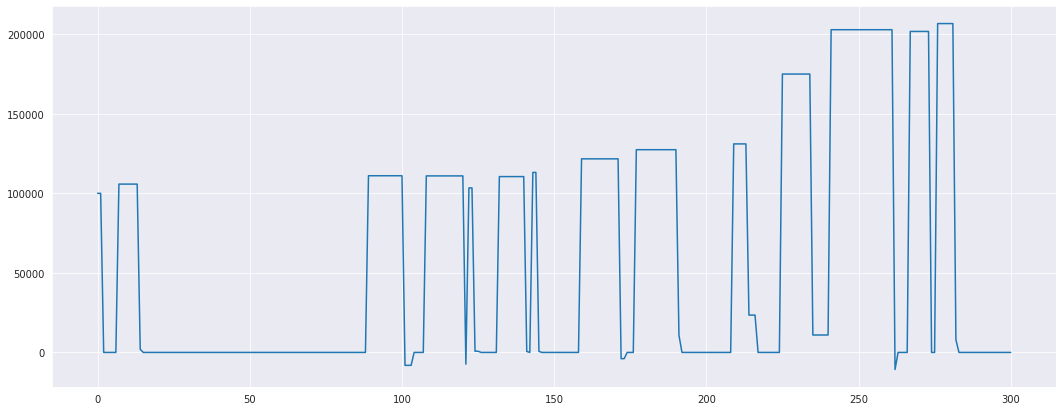

In [58]:
utils.show_data(val_dataset, start=0, end=300, param=['Close']) # Визуализируем обучающий датасет
plt.figure(figsize=(18,7))
plt.plot(money_history)
plt.show()